In [1]:
from min10_categorical_6classes_logScaled import *
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
from PIL import Image
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot
from Utils.eval import *
from tensorflow.keras.optimizers import Adam
import keras.backend.tensorflow_backend
from keras.backend import clear_session
from tensorflow.keras.models import Model,Sequential
from Utils.Dataset import getData
from Utils.transform import cutOut,Normalize,LogBin,LinBin
import os





Num GPUs: 1


Using TensorFlow backend.


In [2]:
source_model,modelpath,train,test = getModel(False)
source_model.summary()
predictions = source_model.layers[-2].output
model = Model(inputs=source_model.inputs, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 5)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 20)   920         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 96, 96, 20)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 48, 48, 20)   0           activation[0][0]                 
______________________________________________________________________________________________

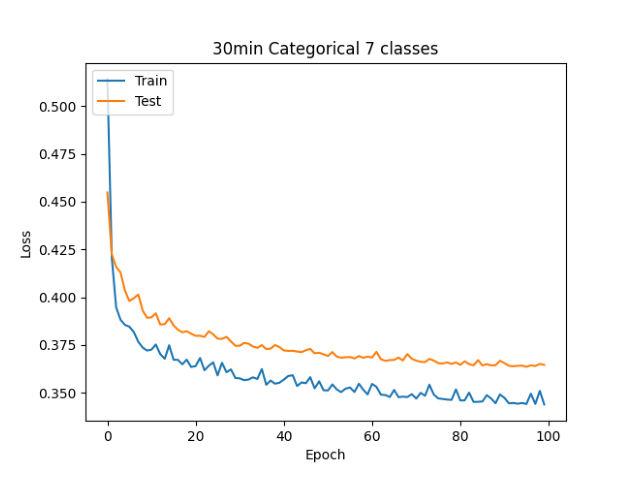

In [3]:
history_path = os.path.join(modelpath,MODELNAME+"_history.png")
figure(num=None, figsize=(10, 30), dpi=80, facecolor='w', edgecolor='k')
loss = np.array(Image.open(history_path))
plt.imshow(loss)
plt.axis('off')
plt.show()


y_transform = [cutOut([16,80,16,80]),LogBin()]

train,test = getData(BATCH_SIZE,
                         DIMENSION,CHANNELS,
                         timeToPred=10,
                         y_transform=y_transform)

In [4]:
history_path = os.path.join(modelpath,MODELNAME+"_history")
laststate = getBestState(modelpath,history_path)
epoch = laststate["epoch"]
model.load_weights(laststate["modelpath"])
test.setWiggle_off()

In [5]:
def getFreshSet(batch_size=1):
    #x_transform = [Normalize(0.007742631458799244, 0.015872015890555563 )]
    
    train,test = getData(batch_size,
                         DIMENSION,CHANNELS,
                         timeToPred=10,
                         y_transform=y_transform)
    return train,test

In [6]:
def categorical(t):
    return tfp.distributions.Independent(
            tfd.Categorical(logits=tf.math.log(t[...,:,:,:]))
            ,name="categorical",reinterpreted_batch_ndims=0 )



pred = None
label = None
pred = 20
test.on_epoch_end()
mean = []
stdev = []
label = []
predictions = []
train,test = getFreshSet(50)

test.setWiggle_off()
atm = []
for x,y in test:
    for i in range(BATCH_SIZE):
        if i < 10:
            continue
        #if y.max() <= 5:
        #    continue
        
        pred = model(np.array([x[i,:,:,:]]) )
        pred = categorical(pred)
        #p= 0
        p = np.arange(1,7)
        m = pred.prob(p)

        max_ = np.argmax(m,axis=-1)


        m = pred.prob(0)
        mask = (m >= 0.5)
        mask = mask[0,:,:,0]
        max_[0,mask] = 0
        
        mean.append(max_)
        #stdev.append(pred.sample())
        label.append(y[i,:,:,:])
        predictions.append((pred,y[i:,:,:]))
        
        a = x[i,:,:,-1] * 256
        for t in y_transform:
            a = t(a)
        atm.append(a)
        if len(label) == 20:
            break
    
    if len(label) == 20:
        break

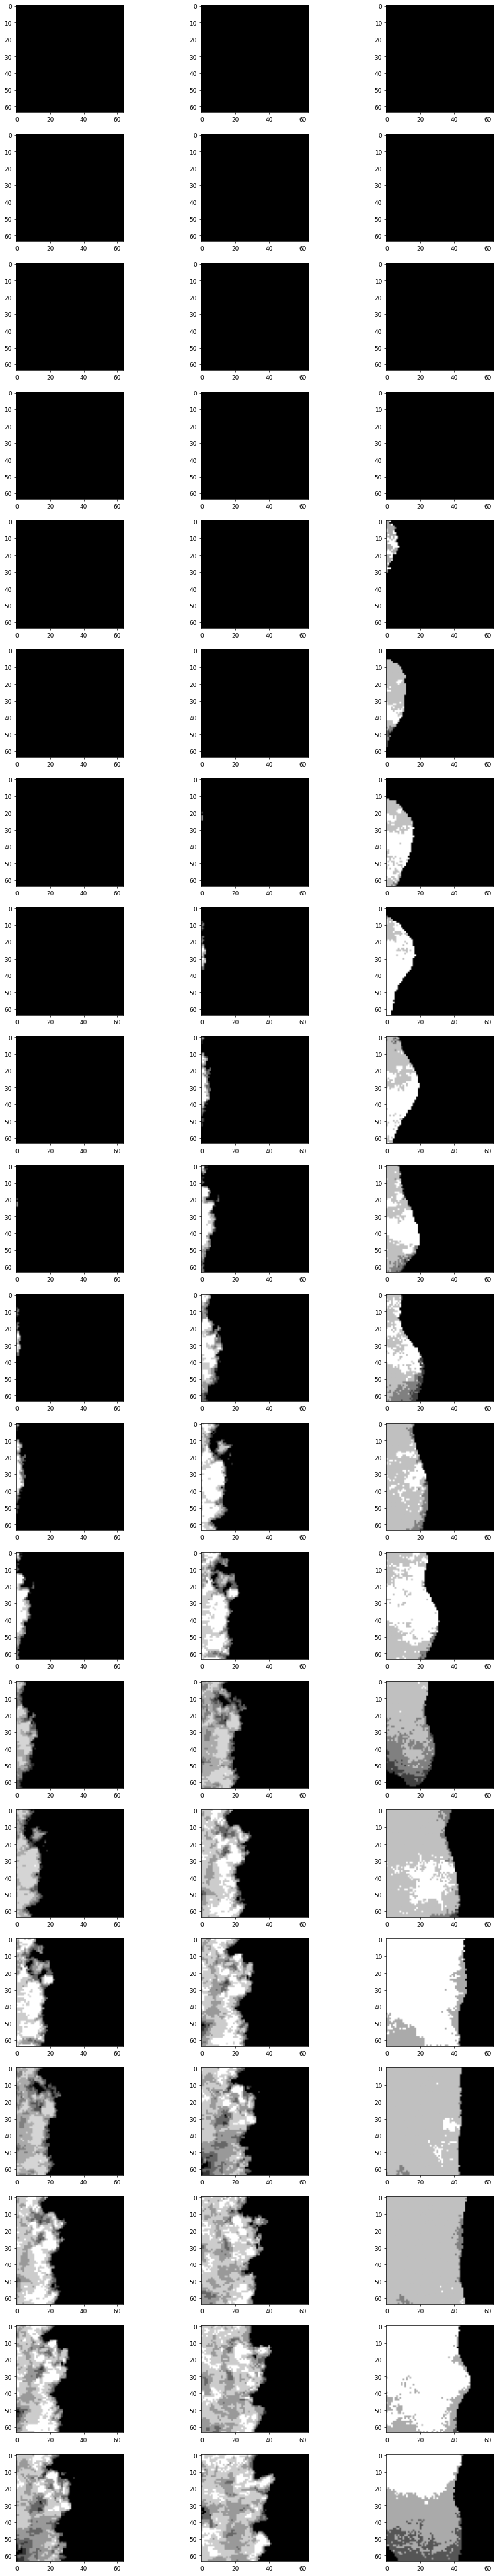

In [7]:
fig, axes = plt.subplots(20, 3, figsize=(16,8*10),dpi=64)
#fig.set_title(["mean","stdev","label"])
#t = cutOut([96,160,96,160])
for batch,img in enumerate(mean):
    if batch == 20:
        break
    axes[batch,2].imshow(img[0,:,:],cmap=plt.get_cmap("gray"))
    #axes[batch,3].imshow(stdev[batch][0,:,:,0],cmap="gray")
    axes[batch,1].imshow(label[batch][:,:,0],cmap=plt.get_cmap("gray"))
    a = atm[batch] 

    #for t in y_transform:
    #    a = t(a)

    axes[batch,0].imshow(a,cmap="gray")
plt.show()

In [8]:
train,test =  getFreshSet(batch_size=100)

In [9]:
a = model(test[0][0])

In [10]:
class Categorical(object):
    """docstring for ClassName"""
    def __init__(self,p):
        super(Categorical, self).__init__()
        self.p = p
        
    def prob(self,value):
        shape = self.p.shape
        if value < 0 or value >= shape[-1]:
            return np.zeros_like(self.p[...,0])
        a = self.p[...,value]
        return a


In [11]:
baseline = multiProc_eval(model,test,getFreshSet,x_transform=[cutOut([16,80,16,80])],dist = Categorical)

Start job:  1
Start job:  2
Start job:  3
Start job:  4
Start job:  5
Start job:  6
Start job:  7
Worker  0 finishedd   2200 images
Worker  1 finishedd   2200 images
Start job:  8
Start job:  9
Worker  2 finishedd   2200 images
Start job:  10
Worker  3 finishedd   2200 images
Start job:  11
Worker  4 finishedd   2200 images
Start job:  12
Worker  5 finishedd   2200 images
Start job:  13
Worker  6 finishedd   2200 images
Start job:  14
Worker  7 finishedd   2200 images
Start job:  15
Worker  8 finishedd   2200 images
Start job:  16
Worker  9 finishedd   2200 images
Start job:  17
Worker 10 finishedd   2200 images
Start job:  18
Worker 11 finishedd   2200 images
Start job:  19
Worker 12 finishedd   2200 images
Start job:  20
Worker 13 finishedd   2200 images
Start job:  21
Worker 14 finishedd   2200 images
Start job:  22
Worker 15 finishedd   2200 images
Start job:  23
Worker 16 finishedd   2200 images
Start job:  24
Worker 17 finishedd   2200 images
Worker 18 finishedd   2200 images
Sta

<Figure size 2000x3000 with 0 Axes>

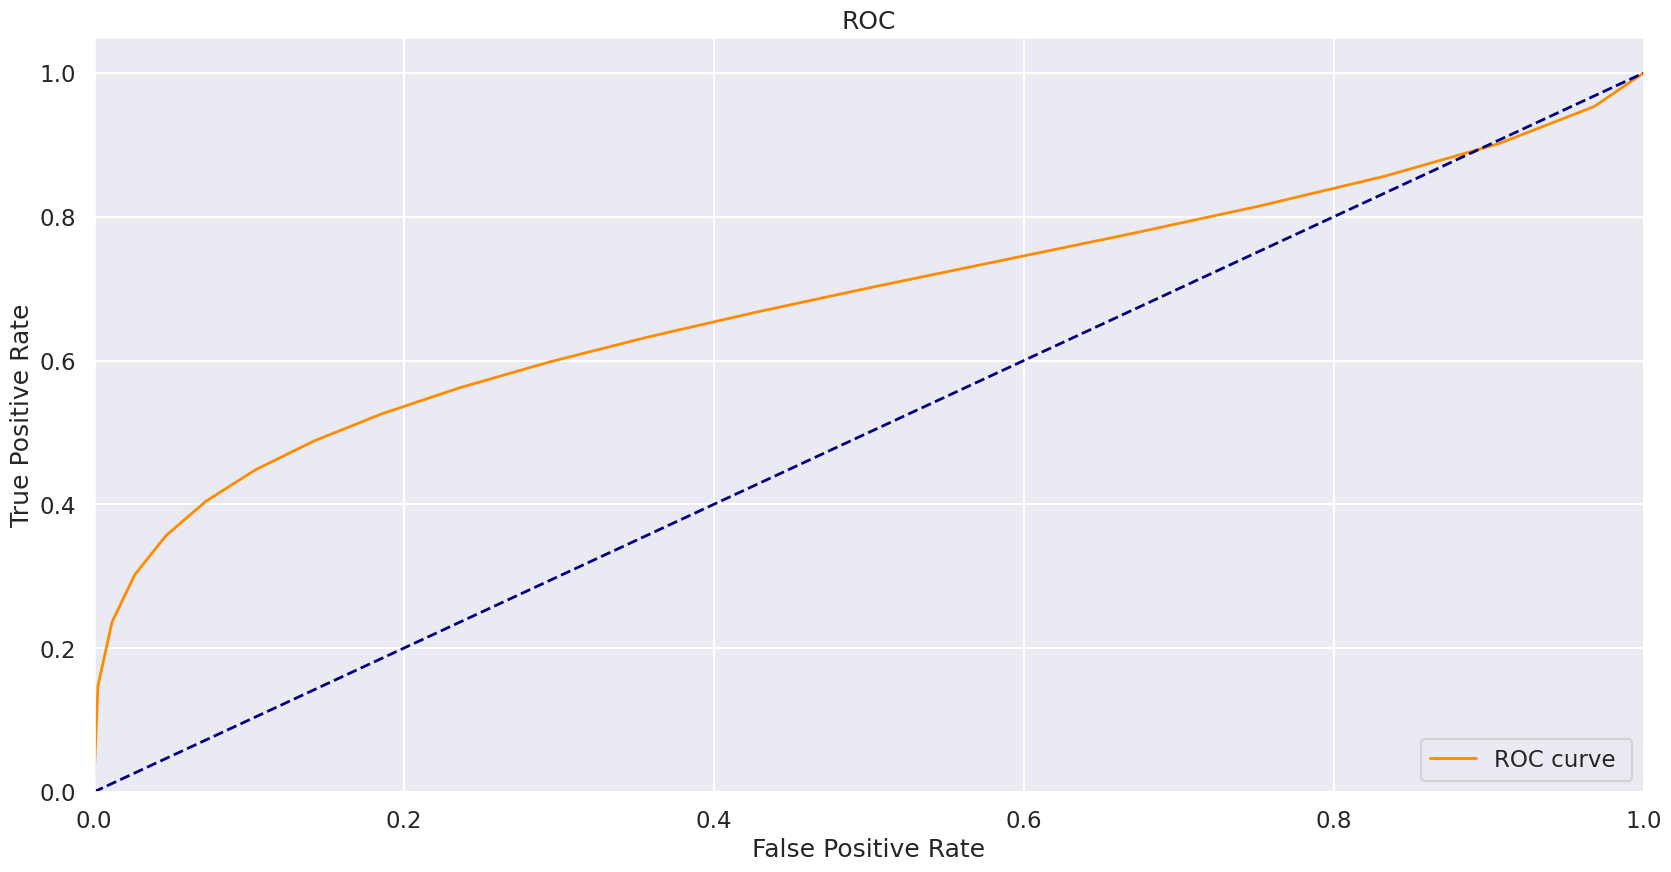

In [12]:
baseline_dict = baseline.copy()
plotAUC(baseline_dict)

In [15]:
a = model(test[0][0])

In [50]:


class Categorical(object):
    """docstring for ClassName"""
    def __init__(self,p):
        super(Categorical, self).__init__()
        self.p = p
        
    def prob(self,value):
        shape = self.p.shape
        if value < 0 or value >= shape[-1]:
            return np.zeros_like(self.p)
        a = self.p[:,:,:,value] 
        return a
    
    def rain(self,threshold=0.5):
        
        p_cpy = np.array(self.p).copy()
        z = np.zeros_like(p_cpy[...,1])
        m = (p_cpy[...,0] >= threshold) 
        
        
        p_cpy[m] = 0.0
        max_ = np.argmax(p_cpy,axis=-1)
        z[~m]= max_[~m]
        return z
    



In [51]:
def histogramm(q,l,last=3,m_labels=256):
    _,x,y,_ = q[0].shape
    
    hist = np.zeros(m_labels)
    hist_q = hist.copy()
        
    for i,d in enumerate(q):
        label = l[i]
        label = label.ravel()
        d = d.reshape(x*y,last)
        for j in range(x*y):
            hist[int(label[j])] += 1
            v = label[j]
            if d[j][0] <= v and d[j][-1] >= v:
                hist_q[int(label[j])] += 1
    return hist,hist_q

In [94]:
q = []
l = []
for j,(x,y) in enumerate(test):
    batch_shape = x.shape[0]
    pred = model(x)
    for i in range(batch_shape):
        l.append(y[i,:,:,:])
        q.append(Categorical(pred[i:i+1,:,:,:]).rain())
        
    if j == 50:
        break

In [95]:
hist,hist_q = histogramm(q,l,last=1,m_labels=7)

(1, 64, 64, 1)


In [102]:
def plotHist(hist,hist_q,min_ = 1,max_=50,title='Liegt im Quantil'):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib import colors
    from matplotlib.ticker import PercentFormatter
    sns.set(style="darkgrid")
    plt.figure(figsize=(20, 10),dpi=100)
    

    hist_n = hist / hist[min_:max_].sum()
    plt.title(title)
    plt.bar(np.arange(min_,max_+1),hist_n[min_:max_+1],color="red",alpha=0.5,lw=.1,label="True")
    plt.ylim([0.0, 0.2])
    plt.xlim([min_, max_])
    plt.xlabel('Label')
    plt.ylabel('relative Häufigkeit')
    #plt.show()

    hist_q_n = hist_q / hist[min_:max_].sum()
    plt.bar(np.arange(min_,max_+1),hist_q_n[min_:max_+1],color="blue",alpha=0.5,lw=.1,label="Vorhersage")
    plt.ylim([0.0, 0.2])
    plt.xlim([min_, max_+1])
    plt.legend(loc="upper right")
    plt.show()

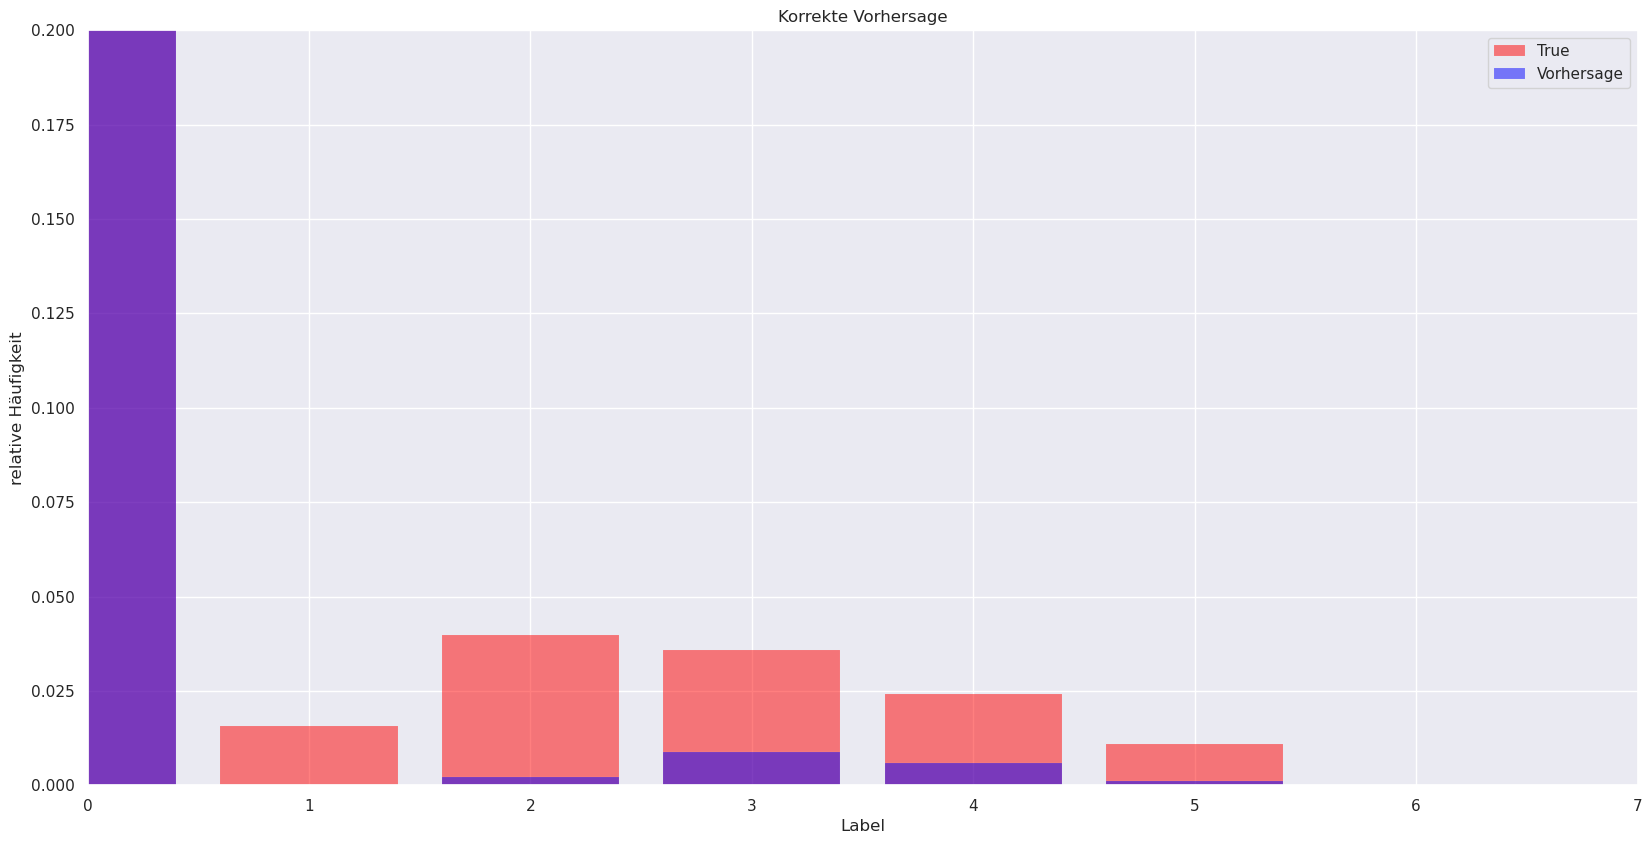

In [103]:

plotHist(hist,hist_q,min_=0,max_=6,title="Korrekte Vorhersage")

In [104]:
someStats(hist,hist_q)

Anzahl an labels           : 20889600.0
Anzahl liegt im C-Intervall 18396077.0 | 0.88:

Ohne Regen
Anzahl an labels           : 2645285.0
Anzahl liegt im C-Intervall: 376357.0 | 0.14%
